# Is humanity's gluttony killing the planet?

With rising life expectancies and a rapid increase in population across the globe, it is getting harder for humanity to sustain its nutritional needs. The inefficient upscale of food production is having a noticeable negative impact on the planet. Deforestation, increased livestock farming, and the excessive use of fertilisers, which are all related to food production, are the main causal factors behind rising emissions in greenhouse gasses and consequently, global warming. In an effort to further the advancements in battling climate change, we aim to reveal how food production and its necessary resources have evolved, and the relation to global warming. We will do so by carrying out an analysis of the data published by the Food and Agriculture Organization of the United Nations (FAOSTAT). We believe that by doing so, we could potentially increase general public awareness of this topic and compel people to keep the stated issue in mind when acting as consumers.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

- How has the world recenlty evolved in terms of factors that are relevant to agriculture and climate change (agricultural activity, CO2 emissions, deforestation, etc.) ? 
- What are the most popular food types (per country and overall) and their relative impact on CO2 emissions ?
- What countries are the most/least efficient in terms of meeting their nutritional needs ?
- How do countries collaborate in order to meet these needs ?
- Are there any trends in the production of different food types ?
- What realizable good practices exist in order to reduce the negative impacts of food production ?

### How has the world recenlty evolved in terms of factors that are relevant to agriculture and climate change?

As an introductory section to this topic, we will explore how various factors that are related to climate change have evolved in recent years and how humanity's agricultural activity contributes to these.

#### Population

First of all, we load the data illustrating the population levels across the world.

In [2]:
population_df = pd.read_csv('data/Population_E_All_Data_(Normalized).zip', encoding='latin-1')
population_df.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
0,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1950,1950,1000 persons,7752.118,X,NaN
1,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1951,1951,1000 persons,7840.156,X,NaN
2,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1952,1952,1000 persons,7935.997,X,NaN
3,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1953,1953,1000 persons,8039.694,X,NaN
4,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1954,1954,1000 persons,8151.317,X,NaN


In [4]:
world_population = population_df[population_df.Area=='World'][['Area', 'Year', 'Element', 'Unit', 'Value']]
food_importing_population = population_df[population_df.Area=='Net Food Importing Developing Countries']\
[['Year', 'Element', 'Value']]
food_deficit_population = population_df[population_df.Area=='Low Income Food Deficit Countries']\
[['Year', 'Element', 'Value']]

In [5]:
food_importing_population = food_importing_population.rename(columns={'Value': 'num_people_imp_countries'})
food_deficit_population = food_deficit_population.rename(columns={'Value': 'num_people_def_countries'})

In [6]:
world_population = pd.merge(world_population, food_importing_population, on=['Year', 'Element'], how='inner')
world_population = pd.merge(world_population, food_deficit_population, on=['Year', 'Element'], how='inner')

In [7]:
world_population['ratio_imp_pop'] = world_population.num_people_imp_countries/world_population.Value
world_population['ratio_def_pop'] = world_population.num_people_def_countries/world_population.Value

In [114]:
world_population = world_population[(world_population.Year<2018) 
                                    & (world_population.Element=='Total Population - Both sexes')]
population_df.Area.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Anguilla', 'Antigua and Barbuda', 'Argentina',
       'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan',
       'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus',
       'Belgium', 'Belgium-Luxembourg', 'Belize', 'Benin', 'Bermuda',
       'Bhutan', 'Bolivia (Plurinational State of)',
       'Bonaire, Sint Eustatius and Saba', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Channel Islands', 'Chile',
       'China', 'China, Hong Kong SAR', 'China, Macao SAR',
       'China, mainland', 'China, Taiwan Province of', 'Colombia',
       'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', "Côte d'Ivoire",
       'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czechia',
       'Czecho

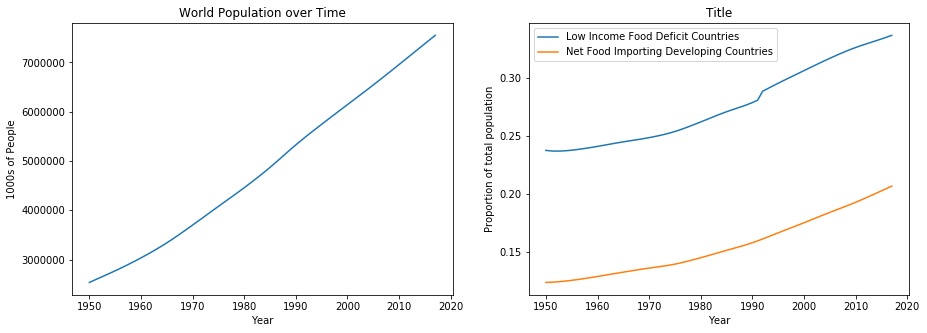

In [117]:
fig = plt.figure(figsize=(15,5))
p1 = fig.add_subplot(121)
p2 = fig.add_subplot(122)
p1.set_title('World Population over Time')
p2.set_title('Title')
p1.plot(world_population.Year.values, world_population.Value.values)
p1.set_xlabel('Year')
p1.set_ylabel('1000s of People')
p2.plot(world_population.Year.values, world_population.ratio_def_pop.values, label='Low Income Food Deficit Countries')
p2.plot(world_population.Year.values, world_population.ratio_imp_pop.values, label='Net Food Importing Developing Countries')
p2.set_xlabel('Year')
p2.set_ylabel('Proportion of total population')
p2.legend()
plt.show()

We can clearly observe that the overall population level of the planet has significantly increased over the past 60 years (going roughly from 2.5 to 7.5 billion). Alongside this, we notice that the proportion of the total population that reside in countries that are either low income food deficit or net food importing countries is also on the rise. This highlights the fact that there is a greater number of humans that rely on limited food production resources.

While processing the data above, we noticed that different levels of aggregation (countries, continents, etc.) are represented as separate rows. In order to obtain the mapping between continents and countries, which will be useful throughout our analysis, we downloaded this information from the FAOSTAT website (as it was not available in the original datasets) and integrated it with the populations data.

In [10]:
country_metadata = pd.read_csv('data/FAOSTAT_data_11-19-2019.csv')
country_metadata.head()

,Country Group Code,Country Group,Country Code,Country,M49 Code,ISO2 Code,ISO3 Code
0,5100,Africa,4,Algeria,12.0,DZ,DZA
1,5100,Africa,7,Angola,24.0,AO,AGO
2,5100,Africa,53,Benin,204.0,BJ,BEN
3,5100,Africa,20,Botswana,72.0,BW,BWA
4,5100,Africa,233,Burkina Faso,854.0,BF,BFA


In [11]:
countries = country_metadata.Country.drop_duplicates().values
continents = country_metadata[(country_metadata['Country Group Code']>5000) & (country_metadata['Country Group Code']%100==0)]
continents = continents['Country Group'].drop_duplicates().values

In [12]:
country_populations = population_df[(population_df.Area.isin(countries)) 
                                    & (population_df.Element=='Total Population - Both sexes')].copy()
country_populations['Population'] = country_populations.Value * 1000
country_populations = country_populations[['Area', 'Year', 'Population']]

In [13]:
country_to_group = country_metadata[['Country Group', 'Country']]

In [14]:
new_population_df = pd.merge(country_populations, country_to_group, 
                            left_on='Area', right_on='Country')
new_population_df = new_population_df[['Year', 'Country Group', 'Country', 'Population']]

In [15]:
new_population_df.head()

,Year,Country Group,Country,Population
0,1950,Asia,Afghanistan,7752118.0
1,1950,Land Locked Developing Countries,Afghanistan,7752118.0
2,1950,Least Developed Countries,Afghanistan,7752118.0
3,1950,Low Income Food Deficit Countries,Afghanistan,7752118.0
4,1950,Net Food Importing Developing Countries,Afghanistan,7752118.0


#### Evolution of temperature levels

Secondly, we visualise the evolution of the average yearly temperature levels.

In [16]:
temperatures_df = pd.read_csv('data/Environment_Temperature_change_E_All_Data_(Normalized).zip', 
                           encoding='latin-1')
temperatures_df.head()

,Area Code,Area,Months Code,Months,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,7001,January,7271,Temperature change,1961,1961,°C,0.993,Fc
1,2,Afghanistan,7001,January,7271,Temperature change,1962,1962,°C,0.137,Fc
2,2,Afghanistan,7001,January,7271,Temperature change,1963,1963,°C,2.441,Fc
3,2,Afghanistan,7001,January,7271,Temperature change,1964,1964,°C,-5.359,Fc
4,2,Afghanistan,7001,January,7271,Temperature change,1965,1965,°C,2.211,Fc


In [17]:
world_temperatures_changes = temperatures_df[(temperatures_df.Area=='World') 
                                             & (temperatures_df.Months=='Meteorological year') 
                                             & (temperatures_df.Element=='Temperature change') ]

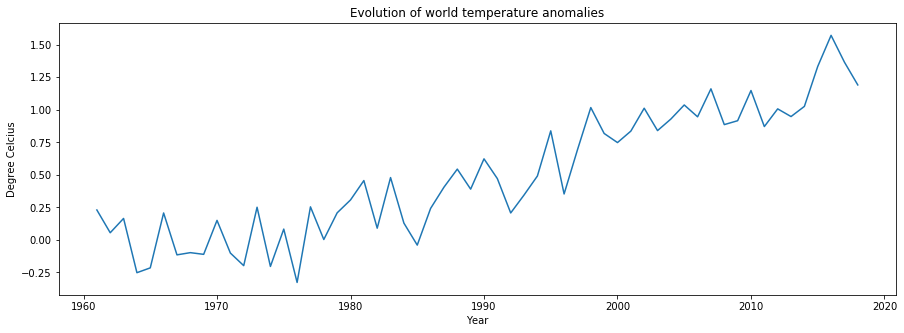

In [18]:
plt.figure(figsize=(15,5))
plt.plot(world_temperatures_changes.Year.values, world_temperatures_changes.Value.values)
plt.title('Evolution of world temperature anomalies')
plt.xlabel('Year')
plt.ylabel('Degree Celcius')
plt.show()

Temperature anomalies indicate how much warmer or colder it is than normal for a particular place and time. Normal always means the average over the 30-year period 1951-1980 for that place and time of year. The increasing trend in temperature is apparent looking only at the data since 1960. These relate to the greenhouse gas emissions that we investigate next.

#### Greenhouse Gas Emissions

In [19]:
emissions_by_sector_df = pd.read_csv('data/Environment_Emissions_by_Sector_E_All_Data_(Normalized).zip', 
                                  encoding='latin-1')

In [20]:
agriculture_emissions_df = pd.read_csv('data/Emissions_Agriculture_Agriculture_total_E_All_Data_(Normalized).zip', 
                                       encoding='latin-1')

In [21]:
emissions_world_sectors = emissions_by_sector_df[(emissions_by_sector_df.Element=='Share of sector in total emissions')
                                                & (emissions_by_sector_df.Area=='World')
                                                & (emissions_by_sector_df.Year==emissions_by_sector_df.Year.max())]

In [22]:
sectors = ['Energy (energy, manufacturing and construction industries and fugitive emissions)', 'Transport', 
           'Residential, commercial, institutional and AFF', 'Industrial processes and product use', 'Waste', 
           'Other sources', 'International bunkers', 'Agriculture total', 'Land use sources']

The above list of sectors was taken from [FAOSTAT official documentation](http://fenixservices.fao.org/faostat/static/documents/EM/EM_e.pdf)

In [23]:
p = emissions_world_sectors[emissions_world_sectors.Item.isin(sectors)]

In [24]:
world_ag_emissions_hist = emissions_by_sector_df[(emissions_by_sector_df.Element=='Share of sector in total emissions')
                                                 & (emissions_by_sector_df.Area=='World')
                                                 & (emissions_by_sector_df.Item=='Agriculture total')]

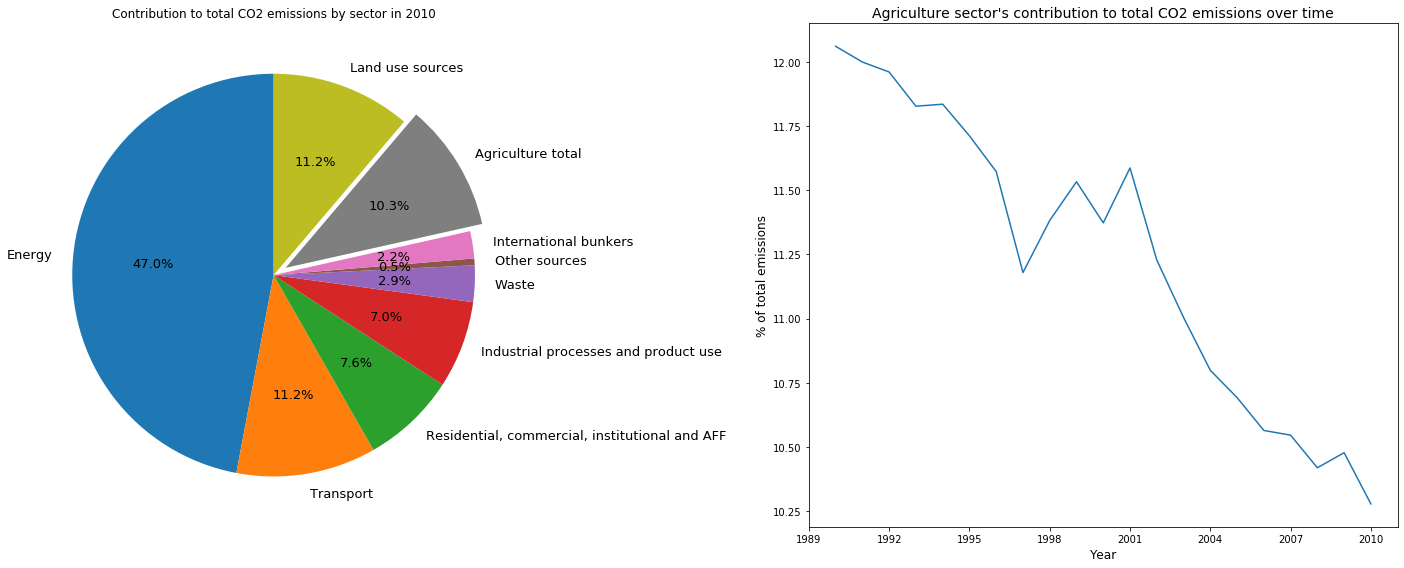

In [25]:
fig = plt.figure(figsize=(20,8))
p1 = fig.add_subplot(121)
p2 = fig.add_subplot(122)
sector_labels = sectors.copy()
sector_labels[0] = 'Energy'
p1.pie(p.Value.values, explode=[0,0,0,0,0,0,0,0.07,0], labels=sector_labels, autopct='%1.1f%%', startangle=90, 
       textprops={'fontsize': 13})
p1.set_title('Contribution to total CO2 emissions by sector in ' + str(p.Year.max()), fontsize=12)
p2.plot(world_ag_emissions_hist.Year.values, world_ag_emissions_hist.Value.values)
p2.set_xlabel('Year', fontsize=12)
p2.set_ylabel('% of total emissions', fontsize=12)
p2.xaxis.set_major_locator(MaxNLocator(integer=True))
p2.set_title("Agriculture sector's contribution to total CO2 emissions over time", fontsize=14)
plt.tight_layout(w_pad=1)
plt.show()

From the pie plot above we can see that agriculture represents a sizeable proportion of total CO2 emissions (about 10%). Note that the biggest proportion of emissions comes from energy (energy, manufacturing and construction industries and fugitive emissions). Although we see that agriculture's share of emissions has decresead over the years (roughly from 12% to 10%), this could be potentially caused by the increase of another sector's share. We explore the evolution of the actual emissions from the agricultural sector below.

In [26]:
world_agriculture_emissions = agriculture_emissions_df[(agriculture_emissions_df.Area=='World') 
                                                       & ~(agriculture_emissions_df.Element.isin(['Emissions (CH4)', 'Emissions (N2O)']))
                                                       & (agriculture_emissions_df.Item=='Agriculture total')
                                                       & (agriculture_emissions_df.Year<2018)]

In [27]:
xticks = world_agriculture_emissions.Year.drop_duplicates().sort_values().values
labels = world_agriculture_emissions.Element.drop_duplicates().values

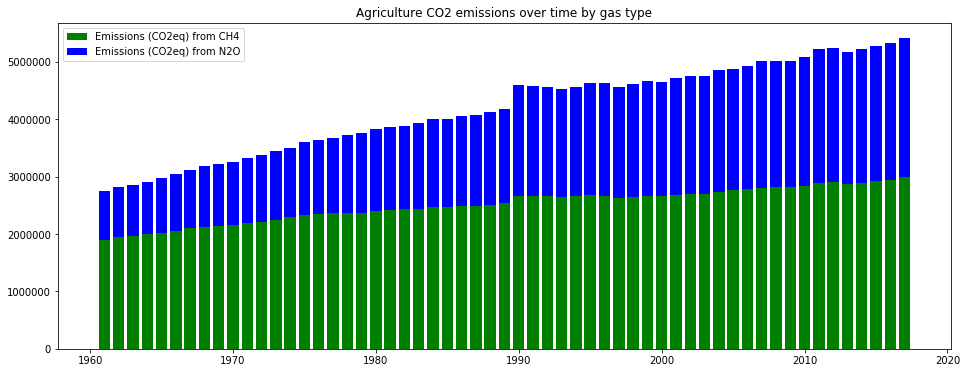

In [28]:
plt.figure(figsize=(16,6))
p1 = plt.bar(xticks, world_agriculture_emissions[world_agriculture_emissions.Element==labels[1]].Value.values, 
             color='g', label=labels[1])
p2 = plt.bar(xticks, world_agriculture_emissions[world_agriculture_emissions.Element==labels[2]].Value.values, 
             bottom=world_agriculture_emissions[world_agriculture_emissions.Element==labels[1]].Value.values, 
             color='b', label=labels[2])
plt.legend()
plt.title('Agriculture CO2 emissions over time by gas type')
plt.show()

From the plot above we see that there is actually a steady increase in CO2 emissions emanating from the agricultural sector. This confirms the previously stated assumptions that although the agricultural sector's share of CO2 emissions has decreased, the actual value of emissions has increased. Additionally, we notice that in 1990 there is a slight abnormal jump in the level of CO2 emissions. Investigating the [FAOSTAT documentation](http://fenixservices.fao.org/faostat/static/documents/GT/GT_e_2019.pdf) related to this dataset, we learned that data for two types of emissions, namely 'Cultivation of organic soils' and 'Burning–savanna', start in 1990 which explains this jump. As such, to have a more illustrative view of the trend in CO2 emissions since 1960 we remove the emission data related to these two items from the dataset and replot.

In [29]:
new_emissions = agriculture_emissions_df[(agriculture_emissions_df.Item.isin(['Cultivation of Organic Soils', 'Burning - Savanna']))
                                         & (agriculture_emissions_df.Area=='World')
                                         & (agriculture_emissions_df.Element=='Emissions (CO2eq)')][['Year', 'Value']]\
                .groupby('Year').agg('sum')
new_emissions.head()

,Value
Year,
1990,403408.5393
1991,403408.5393
1992,403408.5393
1993,403408.5393
1994,403408.5393


In [30]:
population_hist = world_population[['Year', 'Value']].copy()
population_hist['Population'] = 1000 * population_hist.Value

In [31]:
agriculture_co2_emissions = pd.merge(population_hist[['Year', 'Population']], 
                                     world_agriculture_emissions[world_agriculture_emissions.Element==labels[0]],
                                     on='Year')

In [32]:
agriculture_co2_emissions = agriculture_co2_emissions[['Year', 'Population', 'Area', 'Element', 'Unit', 'Value']]
agriculture_co2_emissions.head()

,Year,Population,Area,Element,Unit,Value
0,1961,3.091844e+09,World,Emissions (CO2eq),gigagrams,2.751474e+06
1,1962,3.150421e+09,World,Emissions (CO2eq),gigagrams,2.813011e+06
2,1963,3.211001e+09,World,Emissions (CO2eq),gigagrams,2.849990e+06
3,1964,3.273978e+09,World,Emissions (CO2eq),gigagrams,2.910094e+06
4,1965,3.339584e+09,World,Emissions (CO2eq),gigagrams,2.971073e+06


In [33]:
agriculture_co2_emissions = pd.merge(agriculture_co2_emissions, new_emissions, 
                                     on='Year', how='left', suffixes=('', '_new')).copy()
agriculture_co2_emissions.head()

,Year,Population,Area,Element,Unit,Value,Value_new
0,1961,3.091844e+09,World,Emissions (CO2eq),gigagrams,2.751474e+06,NaN
1,1962,3.150421e+09,World,Emissions (CO2eq),gigagrams,2.813011e+06,NaN
2,1963,3.211001e+09,World,Emissions (CO2eq),gigagrams,2.849990e+06,NaN
3,1964,3.273978e+09,World,Emissions (CO2eq),gigagrams,2.910094e+06,NaN
4,1965,3.339584e+09,World,Emissions (CO2eq),gigagrams,2.971073e+06,NaN


In [34]:
agriculture_co2_emissions.loc[agriculture_co2_emissions.Value_new.isnull(), 'Value_new'] = 0
agriculture_co2_emissions['Value'] = agriculture_co2_emissions.Value - agriculture_co2_emissions.Value_new

In [35]:
agriculture_co2_emissions['ag_co2_pc'] = agriculture_co2_emissions.Value / agriculture_co2_emissions.Population

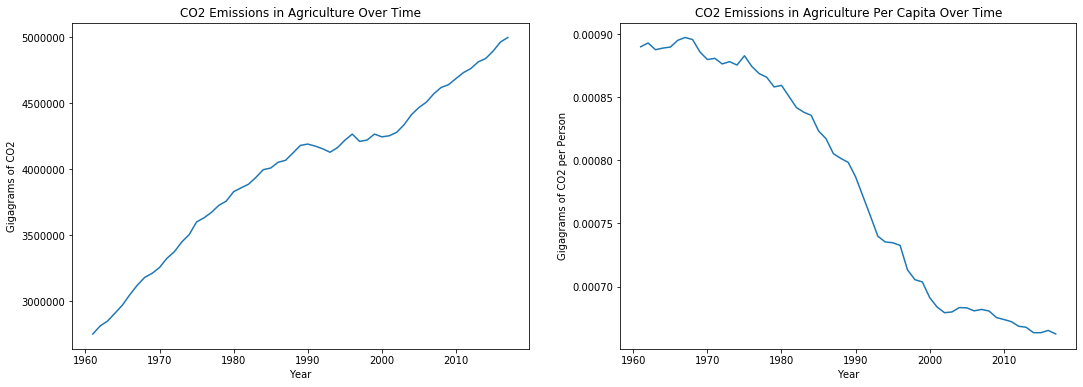

In [36]:
fig = plt.figure(figsize=(18,6))
p1 = fig.add_subplot(121)
p2 = fig.add_subplot(122)
p1.plot(agriculture_co2_emissions.Year.values, agriculture_co2_emissions.Value.values)
p2.plot(agriculture_co2_emissions.Year.values, agriculture_co2_emissions.ag_co2_pc.values)
p1.set_xlabel('Year')
p1.set_ylabel('Gigagrams of CO2')
p1.set_title('CO2 Emissions in Agriculture Over Time')
p2.set_xlabel('Year')
p2.set_ylabel('Gigagrams of CO2 per Person')
p2.set_title('CO2 Emissions in Agriculture Per Capita Over Time')
plt.show()

Having removed the effect of the additional emissions caused by 'Cultivation of organic soils' and 'Burning–savanna', we can now observe a smoother increase in agricultural CO2 emissions over time. Additionally, we also plot the number of gigagrams of agricultural CO2 emissions normalized by the world population as a function of time. We can observe that this curve decreases over time, as opposed to the one relating to the emissions of CO2. We have already observed that the world population has significantly increased over the same time period. This means that the increase in world population is greater than the increase in agricultural CO2 emissions. Since it is safe to assume that the vast majority of the world relies on agriculture for their nutritional needs, this could illustrate the fact that, in terms of efficiency of agricultural activity relative to CO2 emissions, the world has made progress over the last half century. This ties in well with the fact that the world has also made signifcant technological progress over the same time period. We investigate this further later on. Nonetheless, as our initial plot demonstrates, the CO2 levels are rising. A counter balancing factor to CO2 emissions are the carbon-absorbing properties of plants and trees. As such, we investigate the evolution of the world's forest areas below.

#### Forest Area

In [37]:
land_df = pd.read_csv('data/fao_data_land_data.zip', encoding='latin-1')
land_df.head()

,country_or_area,element_code,element,year,unit,value,value_footnotes,category
0,Afghanistan,11,Area,2007.0,1000 Ha,38661.0,Q,agricultural_area
1,Afghanistan,11,Area,2006.0,1000 Ha,38659.0,Fm,agricultural_area
2,Afghanistan,11,Area,2005.0,1000 Ha,38515.0,Fm,agricultural_area
3,Afghanistan,11,Area,2004.0,1000 Ha,38064.0,Fm,agricultural_area
4,Afghanistan,11,Area,2003.0,1000 Ha,38899.0,Fm,agricultural_area


In [38]:
land_df[(land_df.country_or_area=='World +') & (land_df.category=='forest_area')].year.max()

2007.0

As the above land data only goes up to 2007, as opposed to the visualised datasets so far which go up to 2017, we decided to download the data from [FOASTAT](http://www.fao.org/faostat/en/#data/RL) instead.

In [41]:
land_df = pd.read_csv('data/Inputs_LandUse_E_All_Data_(Normalized).zip', encoding='latin-1')
land_df.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,6600,Country area,5110,Area,1961,1961,1000 ha,65286.0,W
1,2,Afghanistan,6600,Country area,5110,Area,1962,1962,1000 ha,65286.0,W
2,2,Afghanistan,6600,Country area,5110,Area,1963,1963,1000 ha,65286.0,W
3,2,Afghanistan,6600,Country area,5110,Area,1964,1964,1000 ha,65286.0,W
4,2,Afghanistan,6600,Country area,5110,Area,1965,1965,1000 ha,65286.0,W


In [42]:
land_df[(land_df.Item=='Forest land') & (land_df.Area=='World') & (land_df.Element=='Area')].head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
167977,5000,World,6646,Forest land,5110,Area,1990,1990,1000 ha,4128269.484,A
167978,5000,World,6646,Forest land,5110,Area,1991,1991,1000 ha,4121002.758,A
167979,5000,World,6646,Forest land,5110,Area,1992,1992,1000 ha,4113736.032,A
167980,5000,World,6646,Forest land,5110,Area,1993,1993,1000 ha,4106469.306,A
167981,5000,World,6646,Forest land,5110,Area,1994,1994,1000 ha,4099202.580,A


# THOMAS

In [43]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [44]:
# Path to raw data
data_path = 'data/'

In [45]:
def select_keywords_related_files(data_path, key_words):
    filenames = [filename for filename in os.listdir(data_path)]
    environment_filenames = list(filter(lambda filename: any(key_word in filename for key_word in key_words), filenames))
    environment_filepaths = list(map(lambda filename: os.path.join(data_path, filename), environment_filenames))
    return environment_filepaths

In [46]:
populations_df = pd.read_csv('data/Population_E_All_Data_(Normalized).zip', encoding='latin-1')
print(populations_df.Element.unique())
print(populations_df.Item.unique())
populations_df['is_country'] = populations_df['Area Code'].apply(lambda code: len(str(code)) < 4)
populations_df = population_df[(population_df.Element == 'Total Population - Both sexes') & (populations_df.is_country)
                               & (populations_df.Year == 2014) & (populations_df.Area != 'China, mainland')]
populations_df = populations_df[['Area', 'Value']].sort_values(by='Value', ascending=False)
populations_df = populations_df.rename(columns={'Value': 'Population'})

['Total Population - Both sexes' 'Total Population - Male'
 'Total Population - Female' 'Rural population' 'Urban population']
['Population - Est. & Proj.']


In [47]:
# Select all files which are related to climate change
emissions_paths = select_keywords_related_files(data_path, key_words=['Emissions'])
emissions_paths

['data/Environment_Emissions_intensities_E_All_Data_(Normalized).zip',
 'data/Emissions_Agriculture_Agriculture_total_E_All_Data_(Normalized).zip',
 'data/Environment_Emissions_by_Sector_E_All_Data_(Normalized).zip']

In [48]:
emissions_df = pd.read_csv('data/Environment_Emissions_intensities_E_All_Data_(Normalized).zip', encoding='latin-1')
#emissions_df = pd.read_csv(emissions_paths[-6], encoding='latin-1')
print(emissions_df.Element.unique())
print(emissions_df.Item.unique())
print(emissions_df.Year.max())
emissions_df[emissions_df.Element == 'Emissions (CO2eq)']

['Emissions intensity' 'Emissions (CO2eq)' 'Production']
['Cereals excluding rice' 'Rice, paddy' 'Meat, cattle'
 'Milk, whole fresh cow' 'Meat, goat' 'Milk, whole fresh goat'
 'Meat, sheep' 'Milk, whole fresh sheep' 'Milk, whole fresh camel'
 'Meat, chicken' 'Eggs, hen, in shell' 'Milk, whole fresh buffalo'
 'Meat, pig' 'Meat, buffalo']
2016


,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
56,2,Afghanistan,1718,Cereals excluding rice,7231,Emissions (CO2eq),1961,1961,gigagrams,402.2165,Fc
57,2,Afghanistan,1718,Cereals excluding rice,7231,Emissions (CO2eq),1962,1962,gigagrams,408.3269,Fc
58,2,Afghanistan,1718,Cereals excluding rice,7231,Emissions (CO2eq),1963,1963,gigagrams,385.7396,Fc
59,2,Afghanistan,1718,Cereals excluding rice,7231,Emissions (CO2eq),1964,1964,gigagrams,406.7923,Fc
60,2,Afghanistan,1718,Cereals excluding rice,7231,Emissions (CO2eq),1965,1965,gigagrams,410.0940,Fc
...,...,...,...,...,...,...,...,...,...,...,...
376370,5873,OECD,1035,"Meat, pig",7231,Emissions (CO2eq),2012,2012,gigagrams,67724.7956,A
376371,5873,OECD,1035,"Meat, pig",7231,Emissions (CO2eq),2013,2013,gigagrams,66945.8132,A
376372,5873,OECD,1035,"Meat, pig",7231,Emissions (CO2eq),2014,2014,gigagrams,69130.9316,A
376373,5873,OECD,1035,"Meat, pig",7231,Emissions (CO2eq),2015,2015,gigagrams,70005.9504,A


In [49]:
emissions_df['is_country'] = emissions_df['Area Code'].apply(lambda code: len(str(code)) < 4)
emissions_country = emissions_df[(emissions_df.Element == 'Emissions (CO2eq)') & (emissions_df.is_country)]
emissions_country_total = emissions_country[emissions_country.Year == 2014][['Area', 'Value']]\
    .groupby('Area', as_index=False).agg('sum').sort_values(by='Value', ascending=False)
emissions_country_total

,Area,Value
38,China,578982.4331
42,"China, mainland",575316.9288
91,India,550253.5783
24,Brazil,407380.3308
206,United States of America,303450.8525
...,...,...
133,Nauru,1.2146
193,Tokelau,0.4189
118,Maldives,0.3593
164,Saint Pierre and Miquelon,0.1673


In [118]:
emissions_normalized = emissions_country_total.merge(populations_df, how='inner')
emissions_normalized['Normalized Emissions'] = emissions_normalized.Value / (1000 * emissions_normalized.Population)
# emissions_normalized.sort_values(by='Normalized Emissions', ascending=False).head(30)

In [51]:
emissions_country = emissions_country[['Area', 'Item', 'Value']].groupby(['Area', 'Item'], as_index=False).agg('mean')
emissions_country = emissions_country.sort_values('Value', ascending=False).groupby(['Area'], as_index=False).first()
#emissions_country.sort_values(by='Value', ascending=False).rename(columns={'Value': })

In [52]:
continents_ = ['Africa', 'Asia', 'Americas', 'Europe', 'Oceania']

In [53]:
world_emissions_intensity = emissions_df[(emissions_df.Element == 'Emissions intensity') & (emissions_df.Area == 'World')]
items = world_emissions_intensity.Item.unique().tolist()
meat = list(filter(lambda x: 'Meat' in x, items))
milk = list(filter(lambda x: 'Milk' in x, items))
remaining = list(set(items) - set(meat + milk))

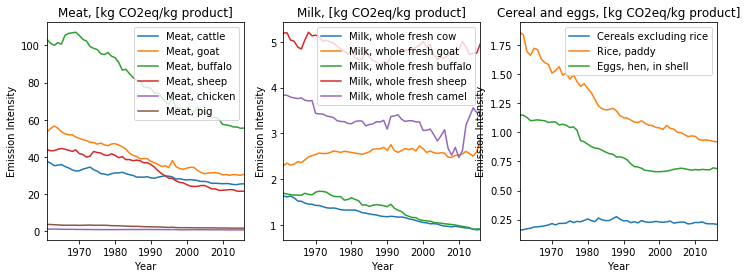

In [121]:
world_emissions_intensity = world_emissions_intensity[['Item', 'Year', 'Value']].groupby(['Item', 'Year'], as_index=False).agg('mean')
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for item in meat:
    world_emissions_intensity[world_emissions_intensity.Item == item].plot(x='Year', y='Value', ax=axes[0], label=item)
    axes[0].legend()
    axes[0].set_ylabel('Emission Intensity')
    axes[0].set_title('Meat, [kg CO2eq/kg product]')
for item in milk:
    world_emissions_intensity[world_emissions_intensity.Item == item].plot(x='Year', y='Value', ax=axes[1], label=item)
    axes[1].legend()
    axes[1].set_ylabel('Emission Intensity')
    axes[1].set_title('Milk, [kg CO2eq/kg product]')
for item in remaining:
    world_emissions_intensity[world_emissions_intensity.Item == item].plot(x='Year', y='Value', ax=axes[2], label=item)
    axes[2].legend()
    axes[2].set_ylabel('Emission Intensity')
    axes[2].set_title('Cereal and eggs, [kg CO2eq/kg product]')

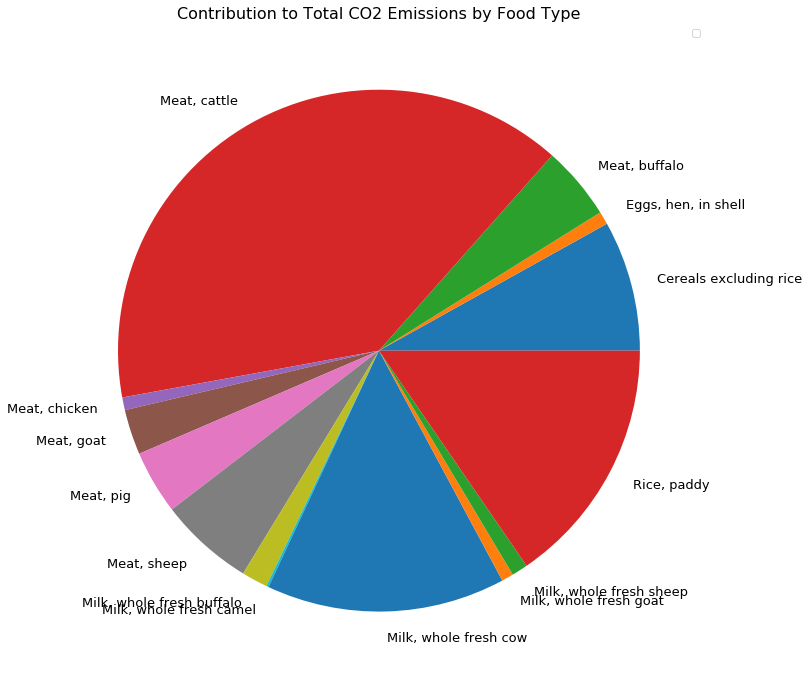

In [165]:
fig, ax = plt.subplots(figsize=(12, 12))
world_net_emissions = emissions_df[(emissions_df.Element == 'Emissions (CO2eq)') & (emissions_df.Area == 'World')]
world_net_emissions[['Item', 'Value']].groupby('Item').agg('sum').plot.pie(y='Value', ax=ax, fontsize=13)
ax.set_ylabel('')
ax.legend('')
ax.set_title('Contribution to Total CO2 Emissions by Food Type', fontsize=16)
plt.show() 

In [167]:
# food_paths = select_keywords_related_files(data_path, key_words=['Food'])
# food_paths

In [168]:
# fao_paths = select_keywords_related_files(data_path, key_words=['fao'])
# fao_paths

In [170]:
fao_crops_df = pd.read_csv('data/fao_data_crops_data.zip', encoding='latin-1')
# fao_crops_df.element.unique()

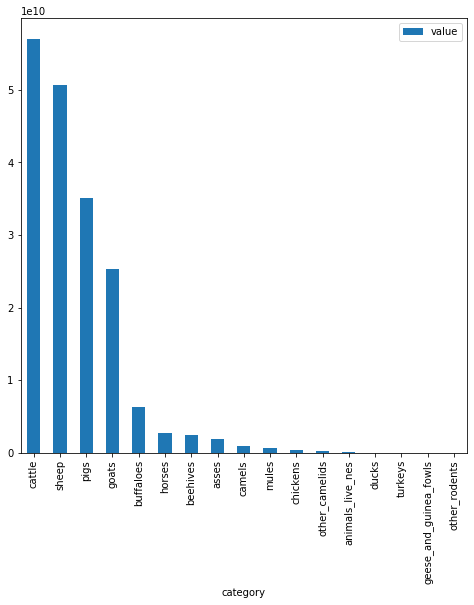

In [177]:
fao_fertilizer_df = pd.read_csv('data/fao_data_fertilizers_data.zip', encoding='latin-1')
fig, ax = plt.subplots(figsize=(8, 8))
world_animals = fao_fertilizer_df[fao_fertilizer_df.country_or_area == 'World +'][['value', 'category']]
world_animals.groupby('category', as_index=False).agg('sum')\
    .sort_values(by='value', ascending=False).plot.bar(x='category', y='value', ax=ax)

plt.show()

In [60]:
rice_prod_df = fao_crops_df[(fao_crops_df.category == 'rice_paddy') & (fao_crops_df.element == 'Production Quantity')]
rice_area_df = fao_crops_df[(fao_crops_df.category == 'rice_paddy') & (fao_crops_df.element == 'Area Harvested')]

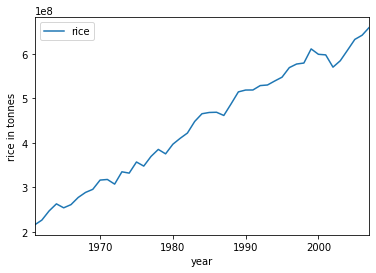

In [61]:
rice_prod_df[rice_prod_df.country_or_area == 'World +'][['year', 'value']].groupby('year').\
    agg(rice=('value', 'sum')).plot(label='rice')
plt.ylabel('rice in tonnes')
plt.legend()

In [62]:
continents = ['Africa +', 'Asia +', 'Americas +', 'Europe +', 'Oceania +']

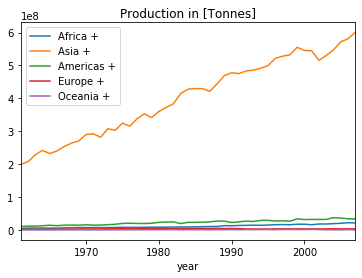

In [63]:
ax = plt.gca()
for continent in continents:
    rice_prod_df[rice_prod_df.country_or_area == continent].groupby('year').agg('sum').plot(ax=ax)
    ax.legend(continents)
    ax.set_title('Production in [Tonnes]')

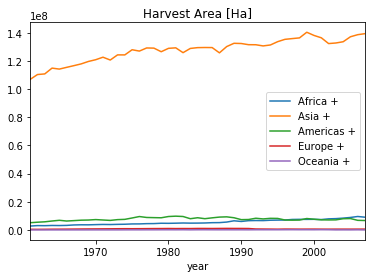

In [64]:
ax = plt.gca()
for continent in continents:
    rice_area_df[rice_area_df.country_or_area == continent].groupby('year').agg('sum').plot(ax=ax)
    ax.legend(continents)
    ax.set_title('Harvest Area [Ha]')

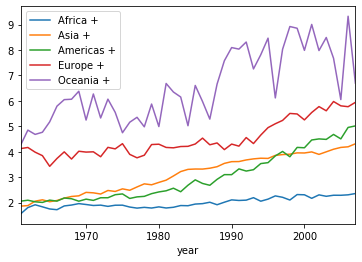

In [65]:
ax = plt.gca()
for continent in continents:
    efficiency_df = rice_prod_df[rice_prod_df.country_or_area == continent].groupby('year').agg('sum') / \
          rice_area_df[rice_area_df.country_or_area == continent].groupby('year').agg('sum')
    efficiency_df.plot(ax=ax)
    ax.legend(continents)

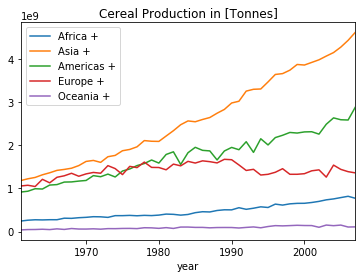

In [66]:
cereal_production_df = fao_crops_df[fao_crops_df.element == 'Production Quantity']
cereal_production_df = cereal_production_df[~cereal_production_df.category.str.contains('total')]
ax = plt.gca()
for continent in continents:
    cereal_production_df[cereal_production_df.country_or_area == continent].groupby('year').agg('sum').plot(ax=ax)
    ax.legend(continents)
    ax.set_title('Cereal Production in [Tonnes]')

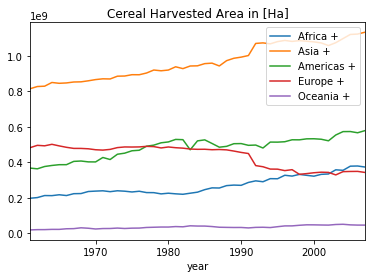

In [67]:
cereal_area_df = fao_crops_df[fao_crops_df.element == 'Area Harvested']
cereal_area_df = cereal_area_df[~cereal_area_df.category.str.contains('total')]
ax = plt.gca()
for continent in continents:
    cereal_area_df[cereal_area_df.country_or_area == continent].groupby('year').agg('sum').plot(ax=ax)
    ax.legend(continents)
    ax.set_title('Cereal Harvested Area in [Ha]')

<Figure size 864x864 with 0 Axes>

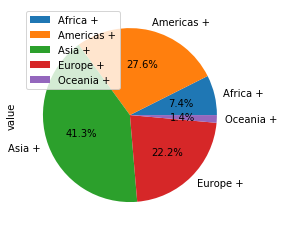

In [68]:
fig = plt.figure(figsize=(12, 12))
continent_production = cereal_production_df[(cereal_production_df.country_or_area.isin(continents)) & \
                                      (~cereal_production_df.category.str.contains('total'))]
continent_production[['country_or_area', 'value']].groupby('country_or_area').agg('sum')\
    .plot.pie(y='value', autopct='%1.1f%%')
plt.legend(loc='upper left')
plt.show()

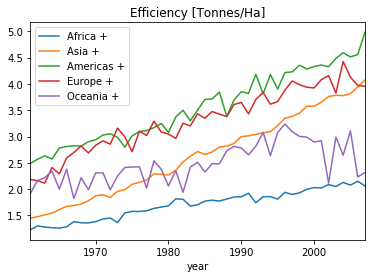

In [69]:
ax = plt.gca()
for continent in continents:
    efficiency_df = cereal_production_df[cereal_production_df.country_or_area == continent].groupby('year').agg('sum') / \
          cereal_area_df[cereal_area_df.country_or_area == continent].groupby('year').agg('sum')
    efficiency_df.plot(ax=ax)
    ax.legend(continents)
    ax.set_title('Efficiency [Tonnes/Ha]')

In [100]:
food_balance_df = pd.read_csv('data/FoodBalanceSheets_E_All_Data_(Normalized).zip', encoding='latin-1')

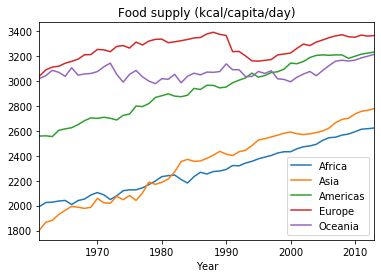

In [101]:
continents = ['Africa', 'Asia', 'Americas', 'Europe', 'Oceania']
cereals_df = food_balance_df[(food_balance_df.Element == 'Food supply (kcal/capita/day)') & 
                (food_balance_df.Item == 'Grand Total')][['Area', 'Year', 'Value']]
cereals_df
ax = plt.gca()
for continent in continents:
    cereals_df[cereals_df.Area == continent].plot(ax=ax, x='Year', y='Value')
    ax.legend(continents)
    ax.set_title('Food supply (kcal/capita/day)')

In [102]:
emissions_df = pd.read_csv('data/Environment_Emissions_intensities_E_All_Data_(Normalized).zip', encoding='latin-1')
emissions_df = emissions_df[emissions_df.Area != 'China']
print(emissions_df.Element.unique())
print(emissions_df.Item.unique())
print(emissions_df.Year.max())
print(emissions_df.Unit.unique())
emissions_df[emissions_df.Element == 'Emissions (CO2eq)']

['Emissions intensity' 'Emissions (CO2eq)' 'Production']
['Cereals excluding rice' 'Rice, paddy' 'Meat, cattle'
 'Milk, whole fresh cow' 'Meat, goat' 'Milk, whole fresh goat'
 'Meat, sheep' 'Milk, whole fresh sheep' 'Milk, whole fresh camel'
 'Meat, chicken' 'Eggs, hen, in shell' 'Milk, whole fresh buffalo'
 'Meat, pig' 'Meat, buffalo']
2016
['kg CO2eq/kg product' 'gigagrams' 'tonnes']


,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
56,2,Afghanistan,1718,Cereals excluding rice,7231,Emissions (CO2eq),1961,1961,gigagrams,402.2165,Fc
57,2,Afghanistan,1718,Cereals excluding rice,7231,Emissions (CO2eq),1962,1962,gigagrams,408.3269,Fc
58,2,Afghanistan,1718,Cereals excluding rice,7231,Emissions (CO2eq),1963,1963,gigagrams,385.7396,Fc
59,2,Afghanistan,1718,Cereals excluding rice,7231,Emissions (CO2eq),1964,1964,gigagrams,406.7923,Fc
60,2,Afghanistan,1718,Cereals excluding rice,7231,Emissions (CO2eq),1965,1965,gigagrams,410.0940,Fc
...,...,...,...,...,...,...,...,...,...,...,...
376370,5873,OECD,1035,"Meat, pig",7231,Emissions (CO2eq),2012,2012,gigagrams,67724.7956,A
376371,5873,OECD,1035,"Meat, pig",7231,Emissions (CO2eq),2013,2013,gigagrams,66945.8132,A
376372,5873,OECD,1035,"Meat, pig",7231,Emissions (CO2eq),2014,2014,gigagrams,69130.9316,A
376373,5873,OECD,1035,"Meat, pig",7231,Emissions (CO2eq),2015,2015,gigagrams,70005.9504,A


In [103]:
emissions_df['is_country'] = emissions_df['Area Code'].apply(lambda code: len(str(code)) < 4)
emissions_country = emissions_df[(emissions_df.Element == 'Emissions (CO2eq)') & (emissions_df.is_country)]
emissions_country_total = emissions_country[emissions_country.Year == 2014][['Area', 'Value']]\
    .groupby('Area', as_index=False).agg('sum').sort_values(by='Value', ascending=False)
emissions_country_total.rename(columns={'Area': 'Country', 'Value': 'Emissions (CO2eq) [gigagrams]'})

,Country,Emissions (CO2eq) [gigagrams]
41,"China, mainland",575316.9288
90,India,550253.5783
24,Brazil,407380.3308
205,United States of America,303450.8525
145,Pakistan,136862.3354
...,...,...
132,Nauru,1.2146
192,Tokelau,0.4189
117,Maldives,0.3593
163,Saint Pierre and Miquelon,0.1673


In [104]:
emissions_intensities_2014_df = emissions_df[(emissions_df.Year == 2014) & (emissions_df.Element == 'Emissions intensity') 
                                       & (emissions_df.is_country)][['Area', 'Item', 'Value']]\
                                        .drop_duplicates().rename(columns={'Area': 'Exporter'})\
                                        .rename(columns={'Value': 'Emissions intensity'}).set_index(['Exporter', 'Item'])
emissions_intensities_2014_df.rename(columns={'Emissions intensity': 'Emissions intensits [kg CO2eq/kg product]'})

Emissions intensits [kg CO2eq/kg product]
Exporter    Item                                                             
Afghanistan Cereals excluding rice                                     0.1206
            Rice, paddy                                                1.3897
            Meat, cattle                                               7.6995
            Milk, whole fresh cow                                      4.7642
            Meat, goat                                                22.2996
...                                                                       ...
Zimbabwe    Meat, goat                                                37.0819
            Meat, sheep                                              153.9554
            Meat, chicken                                              0.7227
            Eggs, hen, in shell                                        1.3571
            Meat, pig                                                  3.1629

[1942 rows x 1 columns]

In [105]:
import_export_df = pd.read_csv('D3/import_export_all_df_2014.csv').set_index(['Exporter', 'Item'])
import_export_df

Importer  \
Exporter                 Item                                               
United States of America Cereals excluding rice                     Japan   
                         Cereals excluding rice                    Mexico   
                         Cereals excluding rice         Republic of Korea   
Canada                   Cereals excluding rice  United States of America   
Russian Federation       Cereals excluding rice                    Turkey   
...                                                                   ...   
New Zealand              Meat, cattle                               Malta   
                         Meat, sheep                     Marshall Islands   
                         Milk, whole fresh cow           Marshall Islands   
                         Milk, whole fresh cow                     Mexico   
Latvia                   Rice, paddy                   Russian Federation   

                                                      Value  
Exporter                 Item                                
United States of America Cereals excluding rice  15743777.0  
                         Cereals excluding rice  13430447.0  
                         Cereals excluding rice   6665503.0  
Canada                   Cereals excluding rice   6017434.0  
Russian Federation       Cereals excluding rice   5687091.0  
...                                                     ...  
New Zealand              Meat, cattle                   1.0  
                         Meat, sheep                    1.0  
                         Milk, whole fresh cow          1.0  
                         Milk, whole fresh cow          1.0  
Latvia                   Rice, paddy                    1.0  

[16527 rows x 2 columns]

In [106]:
emissions_import_export = import_export_df.merge(emissions_intensities_2014_df, how='inner', left_index=True, right_index=True) 
emissions_import_export['Emissions (CO2eq) [gigagrams]'] = emissions_import_export['Value'] *\
    emissions_import_export['Emissions intensity'] / 1000
emissions_import_export = emissions_import_export.reset_index()
emissions_export = emissions_import_export[['Exporter', 'Emissions (CO2eq) [gigagrams]']] \
    .groupby('Exporter').agg('sum').rename(columns={'Emissions (CO2eq) [gigagrams]': 'Out Emissions (CO2eq) [gigagrams]'})
emissions_import = emissions_import_export[['Importer', 'Emissions (CO2eq) [gigagrams]']]\
    .groupby('Importer').agg('sum').rename(columns={'Emissions (CO2eq) [gigagrams]': 'In Emissions (CO2eq) [gigagrams]'})

In [107]:
emissions_country_io = emissions_country_total.merge(emissions_export, how='left', left_on='Area', right_on='Exporter')
emissions_country_io = emissions_country_io.merge(emissions_import, how='left', left_on='Area', right_on='Importer')
emissions_country_io.fillna(value=0.0, inplace=True)
emissions_country_io['Normalized Emissions [gigagrams]'] = emissions_country_io['Value'] - \
    emissions_country_io['Out Emissions (CO2eq) [gigagrams]'] + emissions_country_io['In Emissions (CO2eq) [gigagrams]']
emissions_country_io.sort_values(by='Normalized Emissions [gigagrams]', ascending=False)

,Area,Value,Out Emissions (CO2eq) [gigagrams],In Emissions (CO2eq) [gigagrams],Normalized Emissions [gigagrams]
104,Benin,3901.2577,1.496081e+01,2.058677e+06,2.062563e+06
209,"China, Macao SAR",3.2080,5.347800e-03,1.912015e+06,1.912018e+06
0,"China, mainland",575316.9288,8.052395e+02,1.360206e+05,7.105323e+05
1,India,550253.5783,1.476874e+04,1.612667e+02,5.356461e+05
3,United States of America,303450.8525,2.351151e+04,1.371456e+05,4.170849e+05
...,...,...,...,...,...
214,Saint Pierre and Miquelon,0.1673,0.000000e+00,2.831378e-01,4.504378e-01
212,Tokelau,0.4189,0.000000e+00,0.000000e+00,4.189000e-01
169,Mauritius,134.8978,2.352292e+03,4.265880e+02,-1.790806e+03
127,United Arab Emirates,1508.8755,4.645909e+04,5.418327e+03,-3.953189e+04


In [108]:
emissions_normalized = emissions_country_total.merge(populations_df, how='inner')
emissions_normalized['Normalized Emissions'] = emissions_normalized.Value / (1000 * emissions_normalized.Population)
emissions_normalized.sort_values(by='Normalized Emissions', ascending=False)

,Area,Value,Population,Normalized Emissions
164,Falkland Islands (Malvinas),140.9004,2.792,5.046576e-02
24,New Zealand,36622.1847,4567.527,8.017946e-03
34,Uruguay,23645.1887,3400.436,6.953576e-03
51,Mongolia,15022.5486,2940.108,5.109523e-03
185,Montserrat,20.8016,4.957,4.196409e-03
...,...,...,...,...
170,Singapore,78.2698,5525.626,1.416487e-05
173,"China, Hong Kong SAR",49.0923,7134.670,6.880809e-06
205,"China, Macao SAR",3.2080,590.208,5.435372e-06
209,Maldives,0.3593,435.015,8.259485e-07


In [109]:
emissions_country = emissions_country[['Area', 'Item', 'Value']].groupby(['Area', 'Item'], as_index=False).agg('mean')
emissions_country = emissions_country.sort_values('Value', ascending=False).groupby(['Area'], as_index=False).first()
emissions_country

,Area,Item,Value
0,Afghanistan,"Milk, whole fresh cow",2904.120664
1,Albania,"Milk, whole fresh cow",1122.009702
2,Algeria,"Meat, sheep",1659.206020
3,American Samoa,"Meat, pig",4.223716
4,Angola,"Meat, cattle",3356.722212
...,...,...,...
219,Western Sahara,"Meat, goat",19.267896
220,Yemen,"Meat, cattle",1163.446271
221,Yugoslav SFR,"Milk, whole fresh cow",9215.473961
222,Zambia,"Meat, cattle",2445.534491


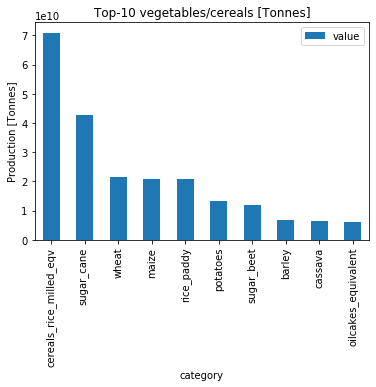

In [70]:
worlds_top_production = fao_crops_df[(fao_crops_df.country_or_area == 'World +') & \
                                     (fao_crops_df.element == 'Production Quantity')][['value', 'category']]
worlds_top_production = worlds_top_production[~worlds_top_production.category.str.contains('total')]
worlds_top_production = worlds_top_production.groupby('category', as_index=False).agg('sum').\
    sort_values(by='value', ascending=False).head(10)
worlds_top_production.plot.bar(x='category', y='value')
plt.title('Top-10 vegetables/cereals [Tonnes]')
plt.ylabel('Production [Tonnes]')
plt.show()

In [71]:
list(filter(lambda x: 'total' in x, fao_crops_df.category.unique()))

['cereals_total',
 'citrus_fruit_total',
 'coarse_grain_total',
 'fruit_excl_melons_total',
 'pulses_total',
 'roots_and_tubers_total',
 'treenuts_total',
 'vegetables_melons_total']

In [72]:
fao_crops_df.year.unique()

array([2007., 2006., 2005., 2004., 2003., 2002., 2001., 2000., 1999.,
       1998., 1997., 1996., 1995., 1994., 1993., 1992., 1991., 1990.,
       1989., 1988., 1987., 1986., 1985., 1984., 1983., 1982., 1981.,
       1980., 1979., 1978., 1977., 1976., 1975., 1974., 1973., 1972.,
       1971., 1970., 1969., 1968., 1967., 1966., 1965., 1964., 1963.,
       1962., 1961.,   nan])

In [76]:
trade_matrix_df = pd.read_csv('data/Trade_DetailedTradeMatrix_E_All_Data_(Normalized).zip', encoding='latin-1')

In [77]:
intensity_dinstinc_items = emissions_df.Item.unique()
trade_matrix_df[trade_matrix_df.Item.str.startswith('Rice')].Item.unique()

array(['Rice - total  (Rice milled equivalent)', 'Rice, milled',
       'Rice, husked', 'Rice, broken'], dtype=object)

In [78]:
# From the FAOSTAT website
cereals = ['Barley',  'Maize',  'Millet',  'Oats', 'Rye', 'Sorghumand', 'Wheat']

def to_cereals(st):
    if st in cereals:
        return 'Cereals excluding rice'
    elif st == 'Rice - total  (Rice milled equivalent)':
        return 'Rice, paddy'
    return st

In [79]:
trade_matrix_df.loc[:, 'Item'] = trade_matrix_df.Item.apply(to_cereals)
trade_matrix_df = trade_matrix_df[trade_matrix_df.Item.isin(intensity_dinstinc_items)]
trade_matrix_df = trade_matrix_df[trade_matrix_df['Partner Countries']!='Unspecified Area']
trade_matrix_df = trade_matrix_df[trade_matrix_df['Reporter Countries']!='Unspecified Area']

In [80]:
stripped_trade_matrix_df = trade_matrix_df[['Reporter Countries', 'Partner Countries', 'Value', 'Year', 'Item']]
stripped_trade_matrix_df.Item.unique()

array(['Cereals excluding rice', 'Meat, chicken', 'Meat, sheep',
       'Rice, paddy', 'Milk, whole fresh cow', 'Eggs, hen, in shell',
       'Meat, cattle', 'Meat, pig', 'Meat, goat',
       'Milk, whole fresh sheep'], dtype=object)

In [81]:
# Export quantity per items
stripped_trade_matrix_df = trade_matrix_df[trade_matrix_df.Year==2014]
exports_2014 = stripped_trade_matrix_df[stripped_trade_matrix_df['Element']=='Export Quantity']
exports_2014 = exports_2014[exports_2014.Value > 0.0][['Reporter Countries', 'Partner Countries', 'Item', 'Value']]
exports_2014 = exports_2014.rename(columns={"Reporter Countries": "Exporter", "Partner Countries": "Importer"})
exports_2014 = exports_2014.groupby(['Exporter', 'Importer', 'Item']).agg('sum').reset_index()

In [82]:
# Import quantity per items
imports_2014 = stripped_trade_matrix_df[stripped_trade_matrix_df['Element']=='Import Quantity']
imports_2014 = imports_2014[imports_2014.Value > 0.0][['Reporter Countries', 'Partner Countries', 'Item', 'Value']]
imports_2014 = imports_2014.rename(columns={"Reporter Countries": "Importer", "Partner Countries": "Exporter"})
imports_2014 = imports_2014.groupby(['Exporter', 'Importer', 'Item']).agg('sum').reset_index()

In [83]:
# All quantity per items
merged_exports_2014 = pd.concat([imports_2014, exports_2014])
merged_exports_2014 = merged_exports_2014.groupby(['Exporter', 'Importer', 'Item']).agg('max').reset_index()
merged_exports_2014 = merged_exports_2014.sort_values(['Value'], ascending=[False])

In [84]:
merged_exports_2014.head(10)

,Exporter,Importer,Item,Value
15766,United States of America,Japan,Cereals excluding rice,15743777.0
15839,United States of America,Mexico,Cereals excluding rice,13430447.0
15966,United States of America,Republic of Korea,Cereals excluding rice,6665503.0
2794,Canada,United States of America,Cereals excluding rice,6017434.0
11760,Russian Federation,Turkey,Cereals excluding rice,5687091.0
414,Australia,"China, mainland",Cereals excluding rice,5395524.0
15542,United States of America,Colombia,Cereals excluding rice,5065605.0
14341,Ukraine,Egypt,Cereals excluding rice,5050364.0
4656,France,Algeria,Cereals excluding rice,4884580.0
1973,Brazil,Iran (Islamic Republic of),Cereals excluding rice,4698583.0


In [85]:
merged_exports_2014.to_csv('D3/import_export_all_df_2014.csv', index=False)

In [86]:
# Exports by total value
exports_2014 = stripped_trade_matrix_df[stripped_trade_matrix_df['Element']=='Export Value']
exports_2014 = exports_2014[exports_2014.Value > 0.0][['Reporter Countries', 'Partner Countries', 'Value']]
exports_2014 = exports_2014.rename(columns={"Reporter Countries": "Exporter", "Partner Countries": "Importer"})
exports_2014 = exports_2014.groupby(['Exporter', 'Importer']).agg('sum').reset_index()

In [87]:
# Imports by total value
imports_2014 = stripped_trade_matrix_df[stripped_trade_matrix_df['Element']=='Import Value']
imports_2014 = imports_2014[imports_2014.Value > 0.0][['Reporter Countries', 'Partner Countries', 'Value']]
imports_2014 = imports_2014.rename(columns={"Reporter Countries": "Importer", "Partner Countries": "Exporter"})
imports_2014 = imports_2014.groupby(['Exporter', 'Importer']).agg('sum').reset_index()

In [88]:
# All total value
merged_exports_2014 = pd.concat([imports_2014, exports_2014])
merged_exports_2014 = merged_exports_2014.groupby(['Exporter', 'Importer']).agg('max').reset_index()
merged_exports_2014 = merged_exports_2014.sort_values(['Value'], ascending=[False])

# Reduce number of edges for graph
value_graph_edges_2014 = merged_exports_2014[merged_exports_2014.Value > 800000.0]
merged_exports_2014.to_csv('D3/import_export_total_value_2014.csv', index=False)

In [89]:
merged_exports_2014.head(10)

,Exporter,Importer,Value
6520,United States of America,Mexico,5613268.0
6499,United States of America,Japan,4645377.0
6549,United States of America,Republic of Korea,2302369.0
1179,Canada,United States of America,2298075.0
214,Australia,"China, mainland",2179980.0
3898,Netherlands,Germany,1830335.0
2113,France,Italy,1656814.0
2327,Germany,Netherlands,1617159.0
2751,India,Saudi Arabia,1520022.0
2298,Germany,Italy,1485865.0


In [91]:
import networkx as nx

In [92]:
G = nx.from_pandas_edgelist(value_graph_edges_2014, 'Exporter', 'Importer', ['Value'], 
                                  create_using=nx.DiGraph())

In [93]:
colors = np.array(value_graph_edges_2014.Value)
colors = np.log(colors)
colors = (colors - colors.min()) / (colors.max() - colors.min())

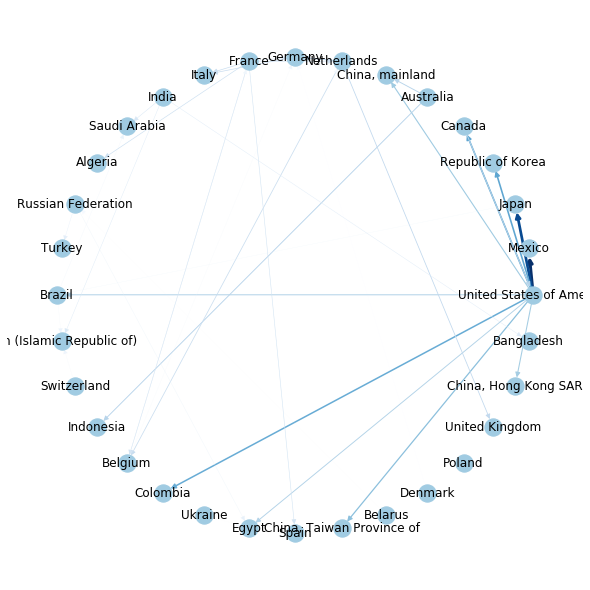

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
pos = nx.circular_layout(G)
nx.draw(G, pos, node_color='#A0CBE2', edge_color=colors,
        width=3*colors, edge_cmap=plt.cm.Blues, with_labels=True)
plt.show()

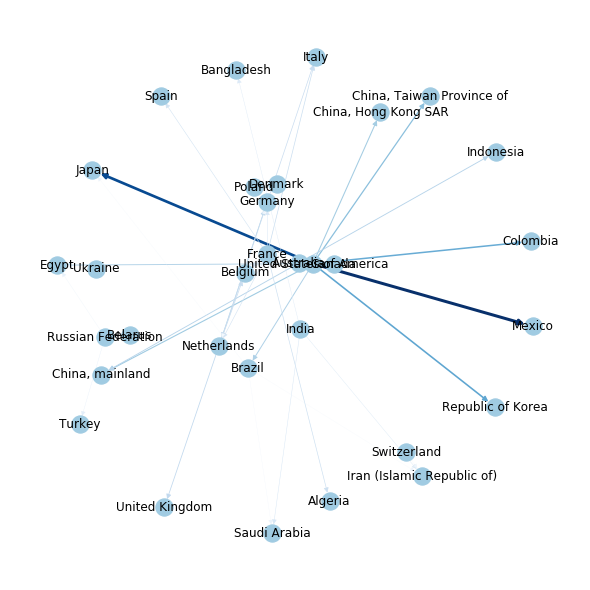

In [95]:
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color='#A0CBE2', edge_color=colors,
        width=3*colors, edge_cmap=plt.cm.Blues, with_labels=True)
plt.show()

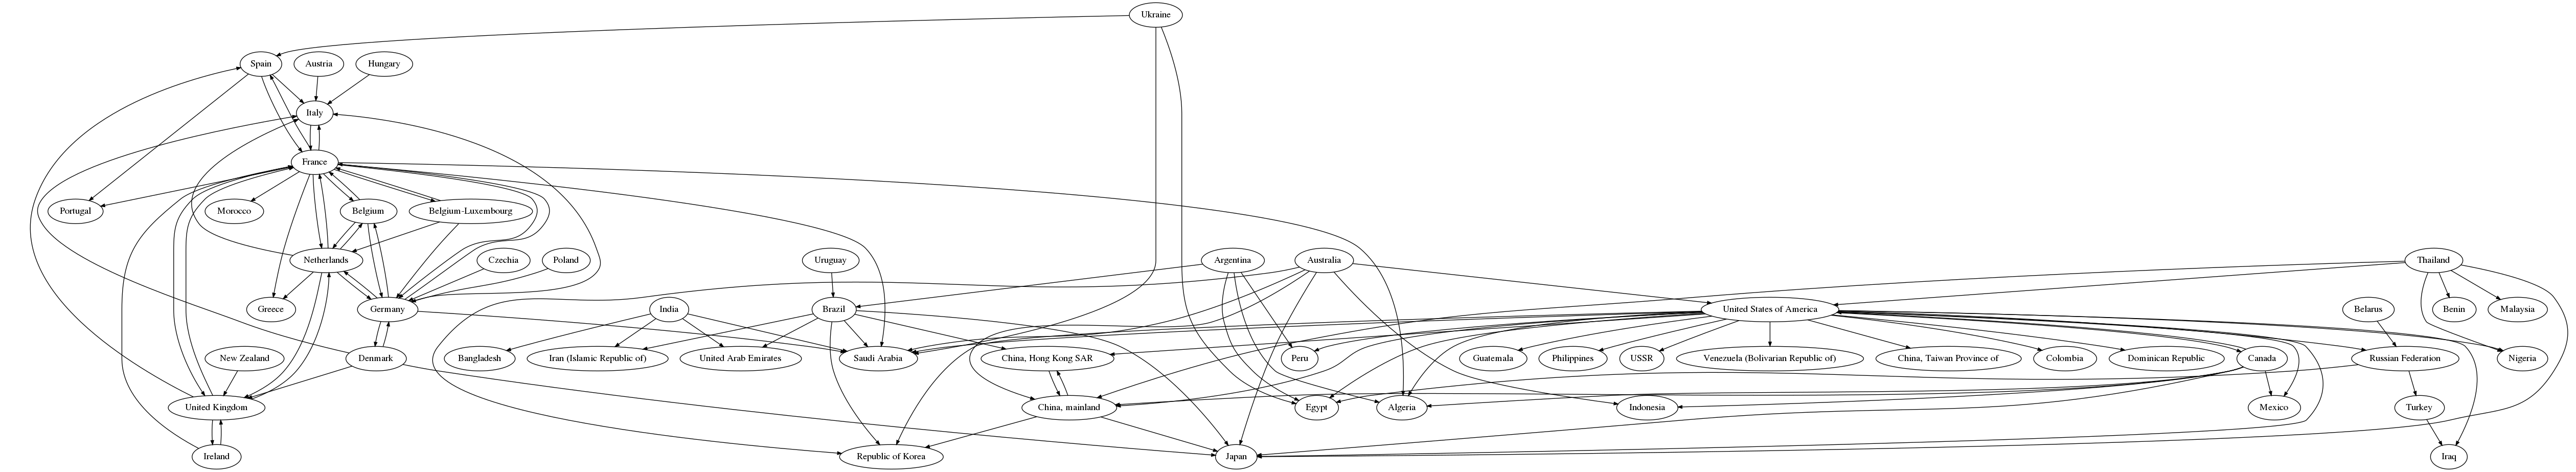

In [97]:
from networkx.drawing.nx_agraph import to_agraph 
from IPython.display import Image

G.graph['edge'] = {'arrowsize': '0.6', 'splines': 'curved'}
# G.graph['graph'] = {'scale': '1'}

A = to_agraph(G)
A.layout('dot')
A.draw('figures/export_import_graph.svg')
Image(filename='figures/export_import_graph.png')

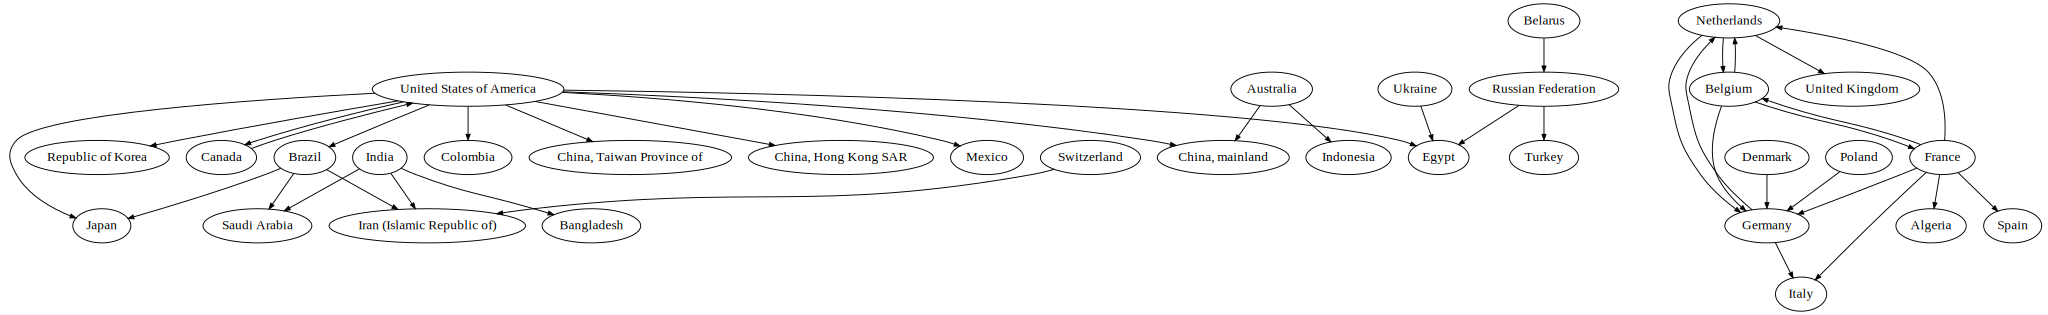

In [98]:
from IPython.core.display import SVG
SVG(filename='figures/export_import_graph.svg')